# Part-2 Train the model

## Import third-party modules

In [1]:
import numpy as np
import shutil
import re
import numpy
import pandas as pd
import csv
import math
import string
import sys
import fileinput
import json
import urllib
import urllib3
import requests
import zipfile
import time
import argparse
import pickle
from termcolor import colored, cprint
import colorama
import webbrowser
import base64
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
import sklearn.ensemble as ske
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict, learning_curve, GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from first_part import URLFeatures,parse_url
from sklearn.ensemble import RandomForestClassifier

## Define functions for valuation of machine learning estimator

1. **get_learning_curve** is used for plotting the train_accuracy,valiadation_accuracy when number of training samples change

In [2]:
def get_learning_curve(estimator, X, y):
    train_size, train_scores, validation_scores = learning_curve(estimator, X, y, train_sizes = np.linspace(0.1, 1, 10), cv = 5)
    # plot the data
    plt.figure(figsize=(12, 8), dpi = 300)
    sizes = np.linspace(0.1, 1, 10)
    plt.plot(sizes, np.average(train_scores, axis=1), color='black',label = 'train accuracy')
    plt.plot(sizes, np.average(validation_scores,axis=1), color='red',label = 'validation accuracy')
    plt.legend(loc='lower right')
    plt.title('Learning curve')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.ylim([0.3, 1.05])

2. **plot_confusion_matrix** is used for plotting the confusion matrix

In [3]:
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # Normalize
    plt.figure(figsize = (12, 8), dpi = 300)
    plt.imshow(cm, interpolation='nearest')    # Display images on specific windows
    plt.title(title)    # Title of the image
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))
    plt.xticks(num_local, labels_name, rotation=90)    
    plt.yticks(num_local, labels_name)    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

3. **plot_ROC_CURVE** is used for plotting the ROC CURVE 

In [4]:
def plot_ROC_CURVE(y,Y):
    # plot ROC curve
    fpr, tpr, threshold = roc_curve(y, Y)  # Calculate TPR and FPR
    roc_auc = auc(fpr, tpr)  # calculate ROC

    plt.figure(figsize = (12, 8), dpi = 300)
    lw = 2
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange',
             lw = lw, label='ROC curve (area = %0.2f)' % roc_auc)  # FPR as x，TPR as y
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

all above function will be  called in **train_model** function

## Main part: define the train_model function
- In this part, we will use Random Forest to train the model with data from part-I and visiualize the result with functions defined above
- Using joblib, we store our trained model in pkl file, so that we can call it from other py files.

1. **Load** data_urls.csv, which was generated by Part-1.ipynb.

In [5]:
df = pd.read_csv('data_urls.csv', sep = '|')
df.head()

,URL,Entropy,BagOfWords,ContainsIP,LengthURL,SpecialChars,SuspiciousStrings,NumberOfDigits,Popularity,Malicious
0,www.businesspage.ecuaradionline.com/9feaf7f835...,4.603980,5,0,69,0,0,19,0,1
1,businesspage.ecuaradionline.com/,3.905639,3,0,32,0,0,0,0,1
2,www.lotto109.com/follow-up/eb6e30faeebb16feaf0...,4.229086,6,0,60,0,0,17,0,1
3,businesspage.ecuaradionline.com/b0028c28760971...,4.518543,4,0,65,0,0,25,0,1
4,businesspageshop.businesspage.ecuaradionline.c...,4.516677,5,0,82,0,0,18,0,1


2. **Extract** features and y-values into corresponding variables.

In [6]:
# Assigns X to features. Drops URL name and label.
X = df.drop(['URL', 'Malicious'], axis = 1).values
feature_names = df.drop(['URL', 'Malicious'], axis = 1).columns
# Assigns y to labels.
y = df['Malicious'].values

3.**Split data** into training and test datasets.

In [7]:
# Split data into training and test datasets.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 0) 

# Print the number of training and testing samples.
print("Training samples: ", len(X_train))
print("Testing samples: ", len(X_test))

Training samples:  8000
Testing samples:  2000


4. Train **Random forest**, **SVM** and **Logistic Regression** algorithm on training dataset.

In [8]:
# Random Forest
clf = RandomForestClassifier(n_jobs = -1, max_features = 'sqrt', n_estimators = 50, oob_score = True, random_state = 0) 

param_grid = { 
    'n_estimators': [50,150,200,250],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_clf = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5)
CV_clf.fit(X_train, y_train)
CV_clf.best_params_

{'max_features': 'auto', 'n_estimators': 200}

Take the best parameters into it.

In [9]:
clf = RandomForestClassifier(n_jobs = -1, max_features = 'auto', n_estimators = 200, oob_score = True, random_state = 0) 

In [10]:
# SVM
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
svm = SVC(kernel = 'rbf', gamma='auto', random_state = 0) 
svm.fit(X_train_std, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [11]:
# Logistic Regression
lr = LogisticRegression(solver='liblinear', random_state = 0)
lr.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

5. Show **accuracy score**, via k-fold method.

In [12]:
# Perform cross validation and print out accuracy on train set
score_train = model_selection.cross_val_score(clf, X_train, y_train, cv=10)
print("Cross Validation Score on train set: {0:.2%}".format(score_train.mean()))
score_svm_train = model_selection.cross_val_score(svm, X_train_std, y_train, cv=10)
print("Cross Validation Score of SVM on train set: {0:.2%}".format(score_svm_train.mean()))
score_lr_train = model_selection.cross_val_score(lr, X_train_std, y_train, cv=10)
print("Cross Validation Score of LR on train set : {0:.2%}".format(score_lr_train.mean()))

Cross Validation Score on train set: 89.54%
Cross Validation Score of SVM on train set: 85.00%
Cross Validation Score of LR on train set : 80.74%


In [13]:
# Perform cross validation and print out accuracy on test set
score = model_selection.cross_val_score(clf, X_test, y_test, cv=10)
print("Cross Validation Score on test set: {0:.2%}".format(score.mean()))
score_svm = model_selection.cross_val_score(svm, X_test_std, y_test, cv=10)
print("Cross Validation Score of SVM on test set: {0:.2%}".format(score_svm.mean()))
score_lr = model_selection.cross_val_score(lr, X_test_std, y_test, cv=10)
print("Cross Validation Score of LR on test set: {0:.2%}".format(score_lr.mean()))

Cross Validation Score on test set: 87.85%
Cross Validation Score of SVM on test set: 82.80%
Cross Validation Score of LR on test set: 82.45%


6. Calculate **F1-score**, **Precision** and **Recall**

In [14]:
y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
y_train_pred_svm = cross_val_predict(svm, X_train_std, y_train, cv=3)
y_train_pred_lr = cross_val_predict(lr, X_train_std, y_train, cv=3)
f = f1_score(y_train, y_train_pred)
f_svm = f1_score(y_train, y_train_pred_svm)
f_lr = f1_score(y_train, y_train_pred_lr)
print("F1 Score of RF: {0:.2%}".format(f))
print("F1 Score of SVM: {0:.2%}".format(f_svm))
print("F1 Score of LR: {0:.2%}".format(f_lr))
p = precision_score(y_train, y_train_pred)
p_svm = precision_score(y_train, y_train_pred_svm)
p_lr = precision_score(y_train, y_train_pred_lr)
print("Precision Score of RF: {0:.2%}".format(p))
print("Precision Score of SVM: {0:.2%}".format(p_svm))
print("Precision Score of LR: {0:.2%}".format(p_lr))
r = recall_score(y_train, y_train_pred)
r_svm = recall_score(y_train, y_train_pred_svm)
r_lr = recall_score(y_train, y_train_pred_lr)
print("Recall Score of RF: {0:.2%}".format(r))
print("Recall Score of SVM: {0:.2%}".format(r_svm))
print("Recall Score of LR: {0:.2%}".format(r_lr))

F1 Score of RF: 89.33%
F1 Score of SVM: 86.30%
F1 Score of LR: 82.58%
Precision Score of RF: 88.02%
Precision Score of SVM: 77.60%
Precision Score of LR: 75.61%
Recall Score of RF: 90.68%
Recall Score of SVM: 97.21%
Recall Score of LR: 90.95%


7. Plot **ROC Curve**.

<Figure size 3600x2400 with 0 Axes>

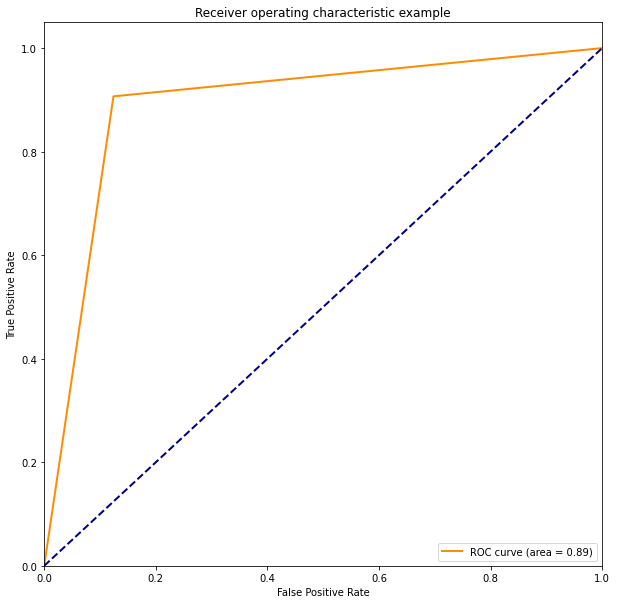

In [15]:
plot_ROC_CURVE(y_train, y_train_pred)
#plt.savefig('../image/ROC.jpg', dpi = 300)
plt.show()

8. Plot **Confusion Matrix**.

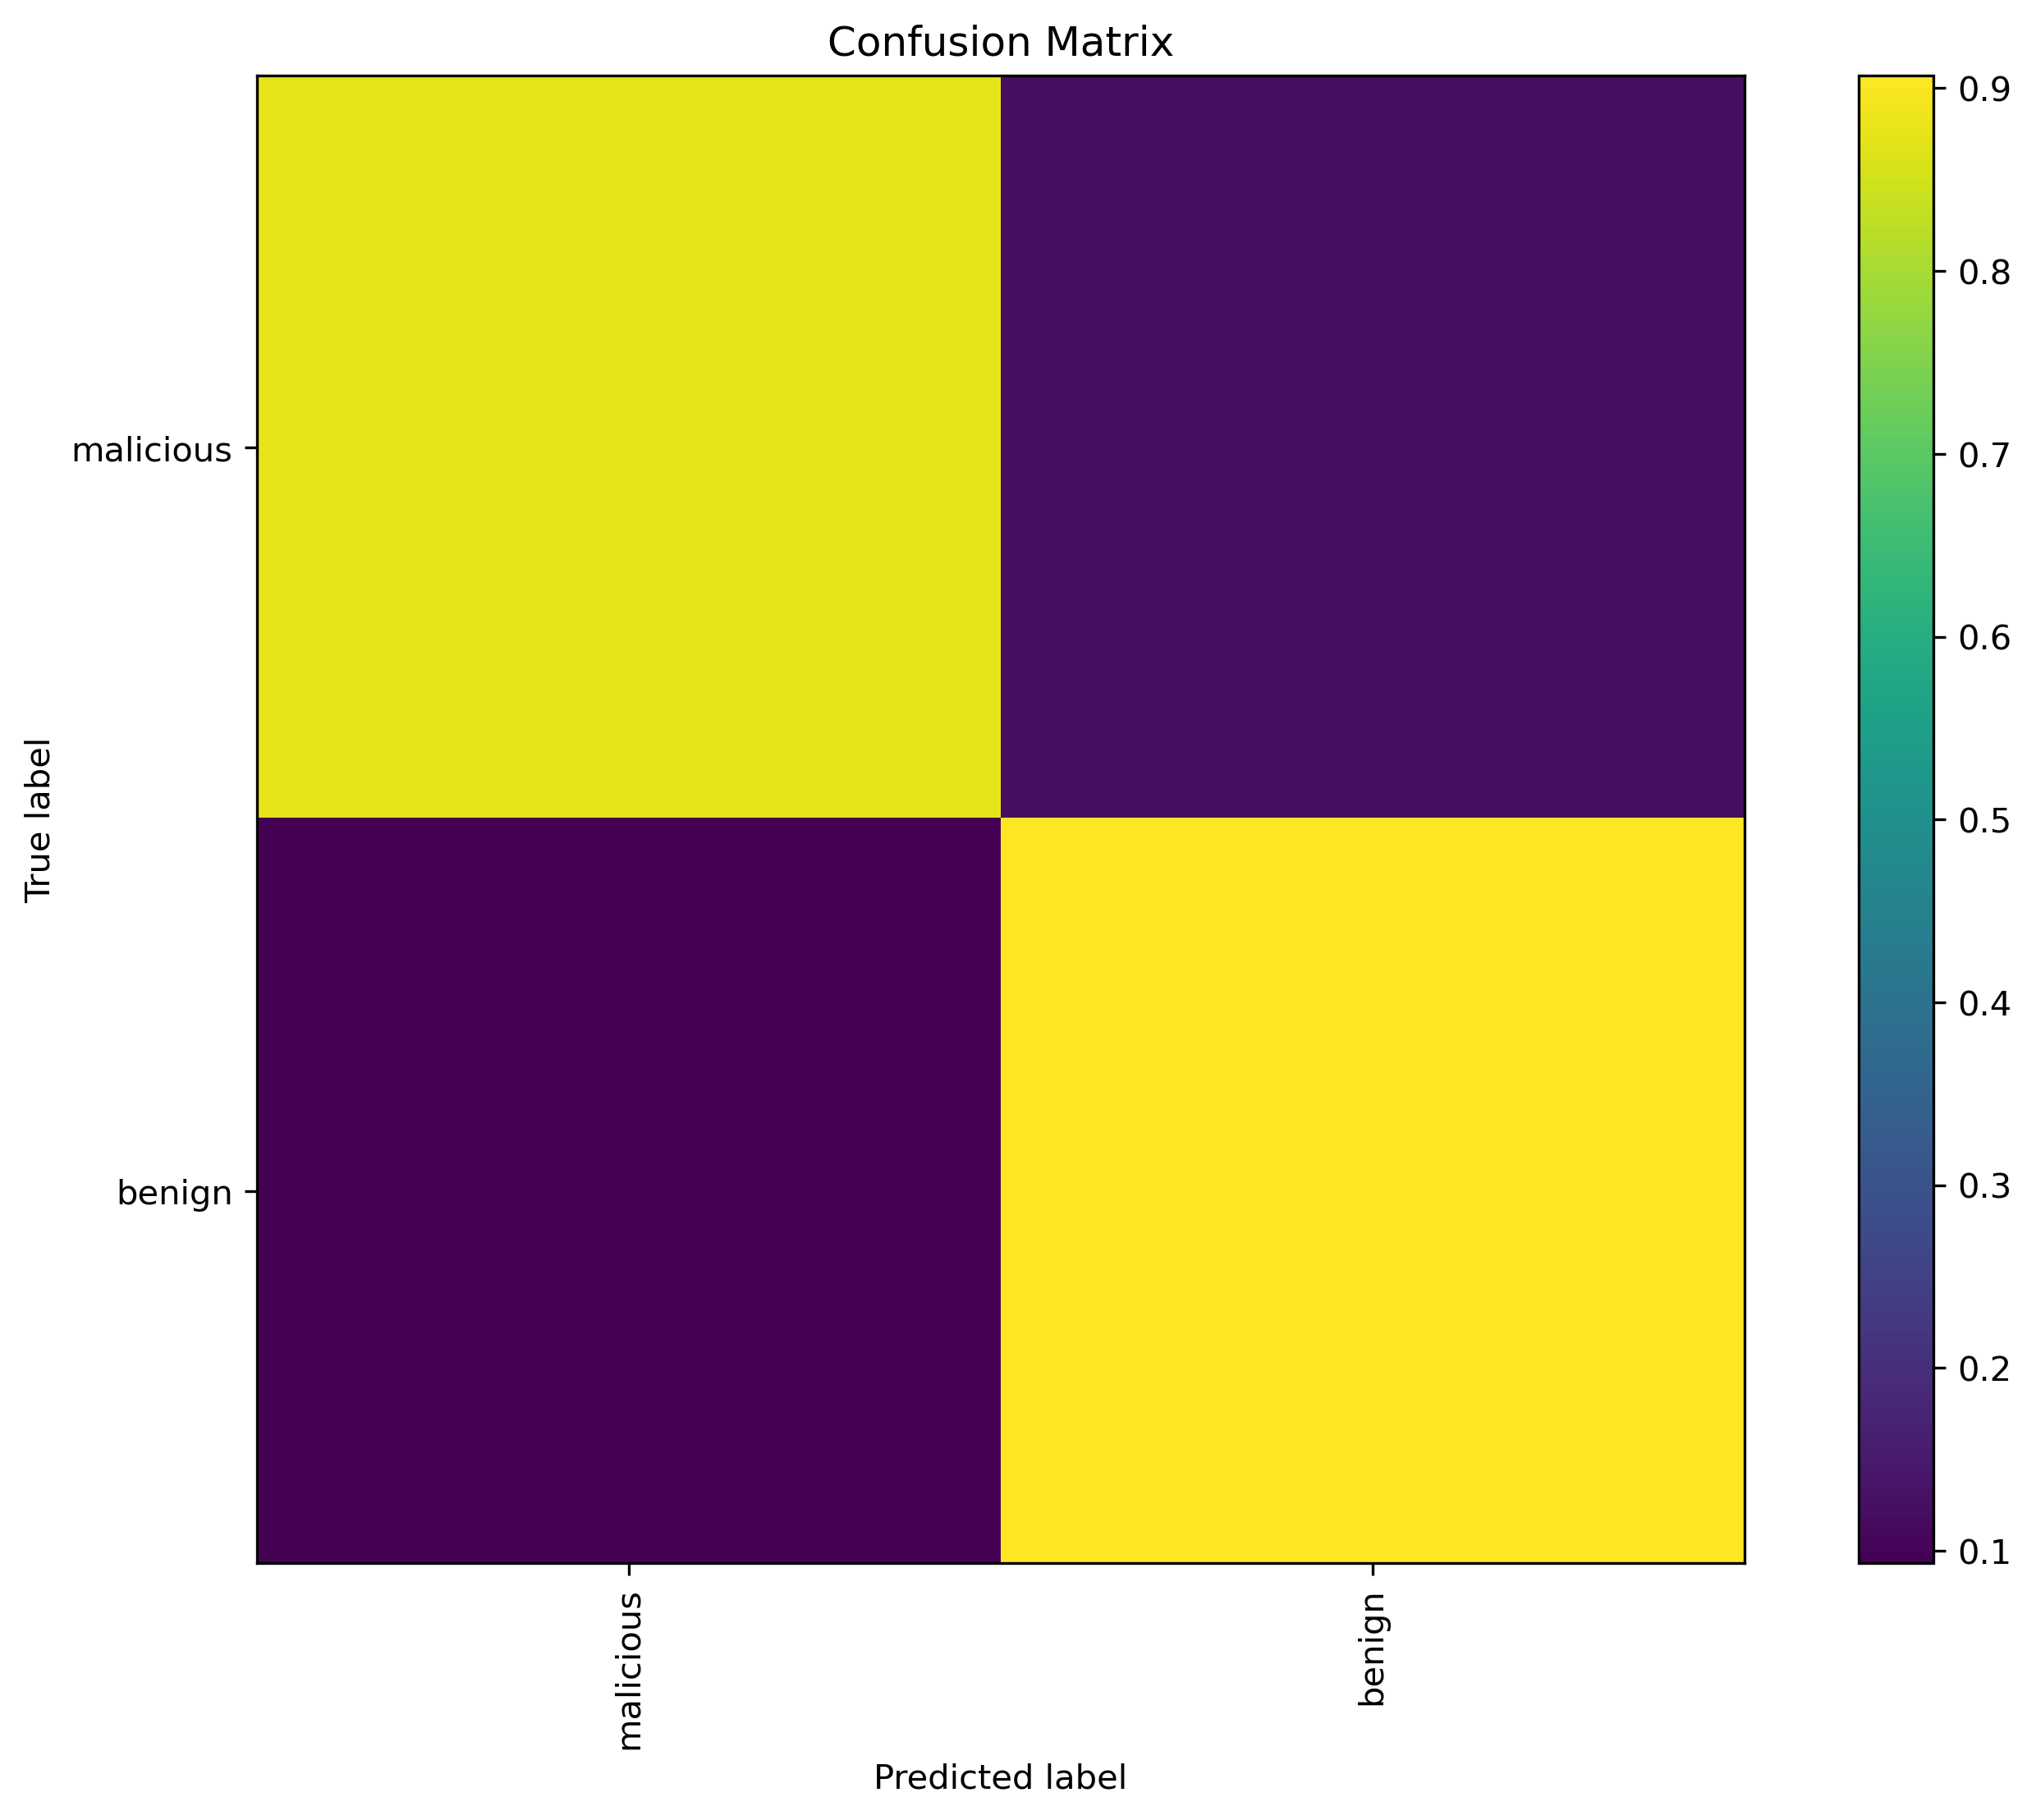

In [16]:
cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, ["malicious", "benign"], "Confusion Matrix")
#plt.savefig('../image/confusion_matrix.jpg', dpi = 300)
plt.show()

9. Analysis of importance of features.

Get the importance of features

In [17]:
clf.fit(X_train,y_train)
feature_importance = clf.feature_importances_
importance_dict = dict(zip(feature_names, feature_importance))
print("importance of feature:",importance_dict)

importance of feature: {'Entropy': 0.2007109918451086, 'BagOfWords': 0.10360834920872872, 'ContainsIP': 0.004689414567023401, 'LengthURL': 0.13713054771363833, 'SpecialChars': 0.012383952140909229, 'SuspiciousStrings': 0.03654809260367959, 'NumberOfDigits': 0.20614362855798588, 'Popularity': 0.2987850233629262}


Sort the importance descend

In [18]:
feature_index_sorted = np.argsort(-feature_importance)
feature_importance_sorted = sorted(feature_importance,reverse=True)
print("index of sorted feature:",feature_index_sorted)
importance_dict_sorted = dict(zip(feature_names[feature_index_sorted],feature_importance_sorted))
print("sorted importance of feature:",importance_dict_sorted)

index of sorted feature: [7 6 0 3 1 5 4 2]
sorted importance of feature: {'Popularity': 0.2987850233629262, 'NumberOfDigits': 0.20614362855798588, 'Entropy': 0.2007109918451086, 'LengthURL': 0.13713054771363833, 'BagOfWords': 0.10360834920872872, 'SuspiciousStrings': 0.03654809260367959, 'SpecialChars': 0.012383952140909229, 'ContainsIP': 0.004689414567023401}


Plot the importance of features

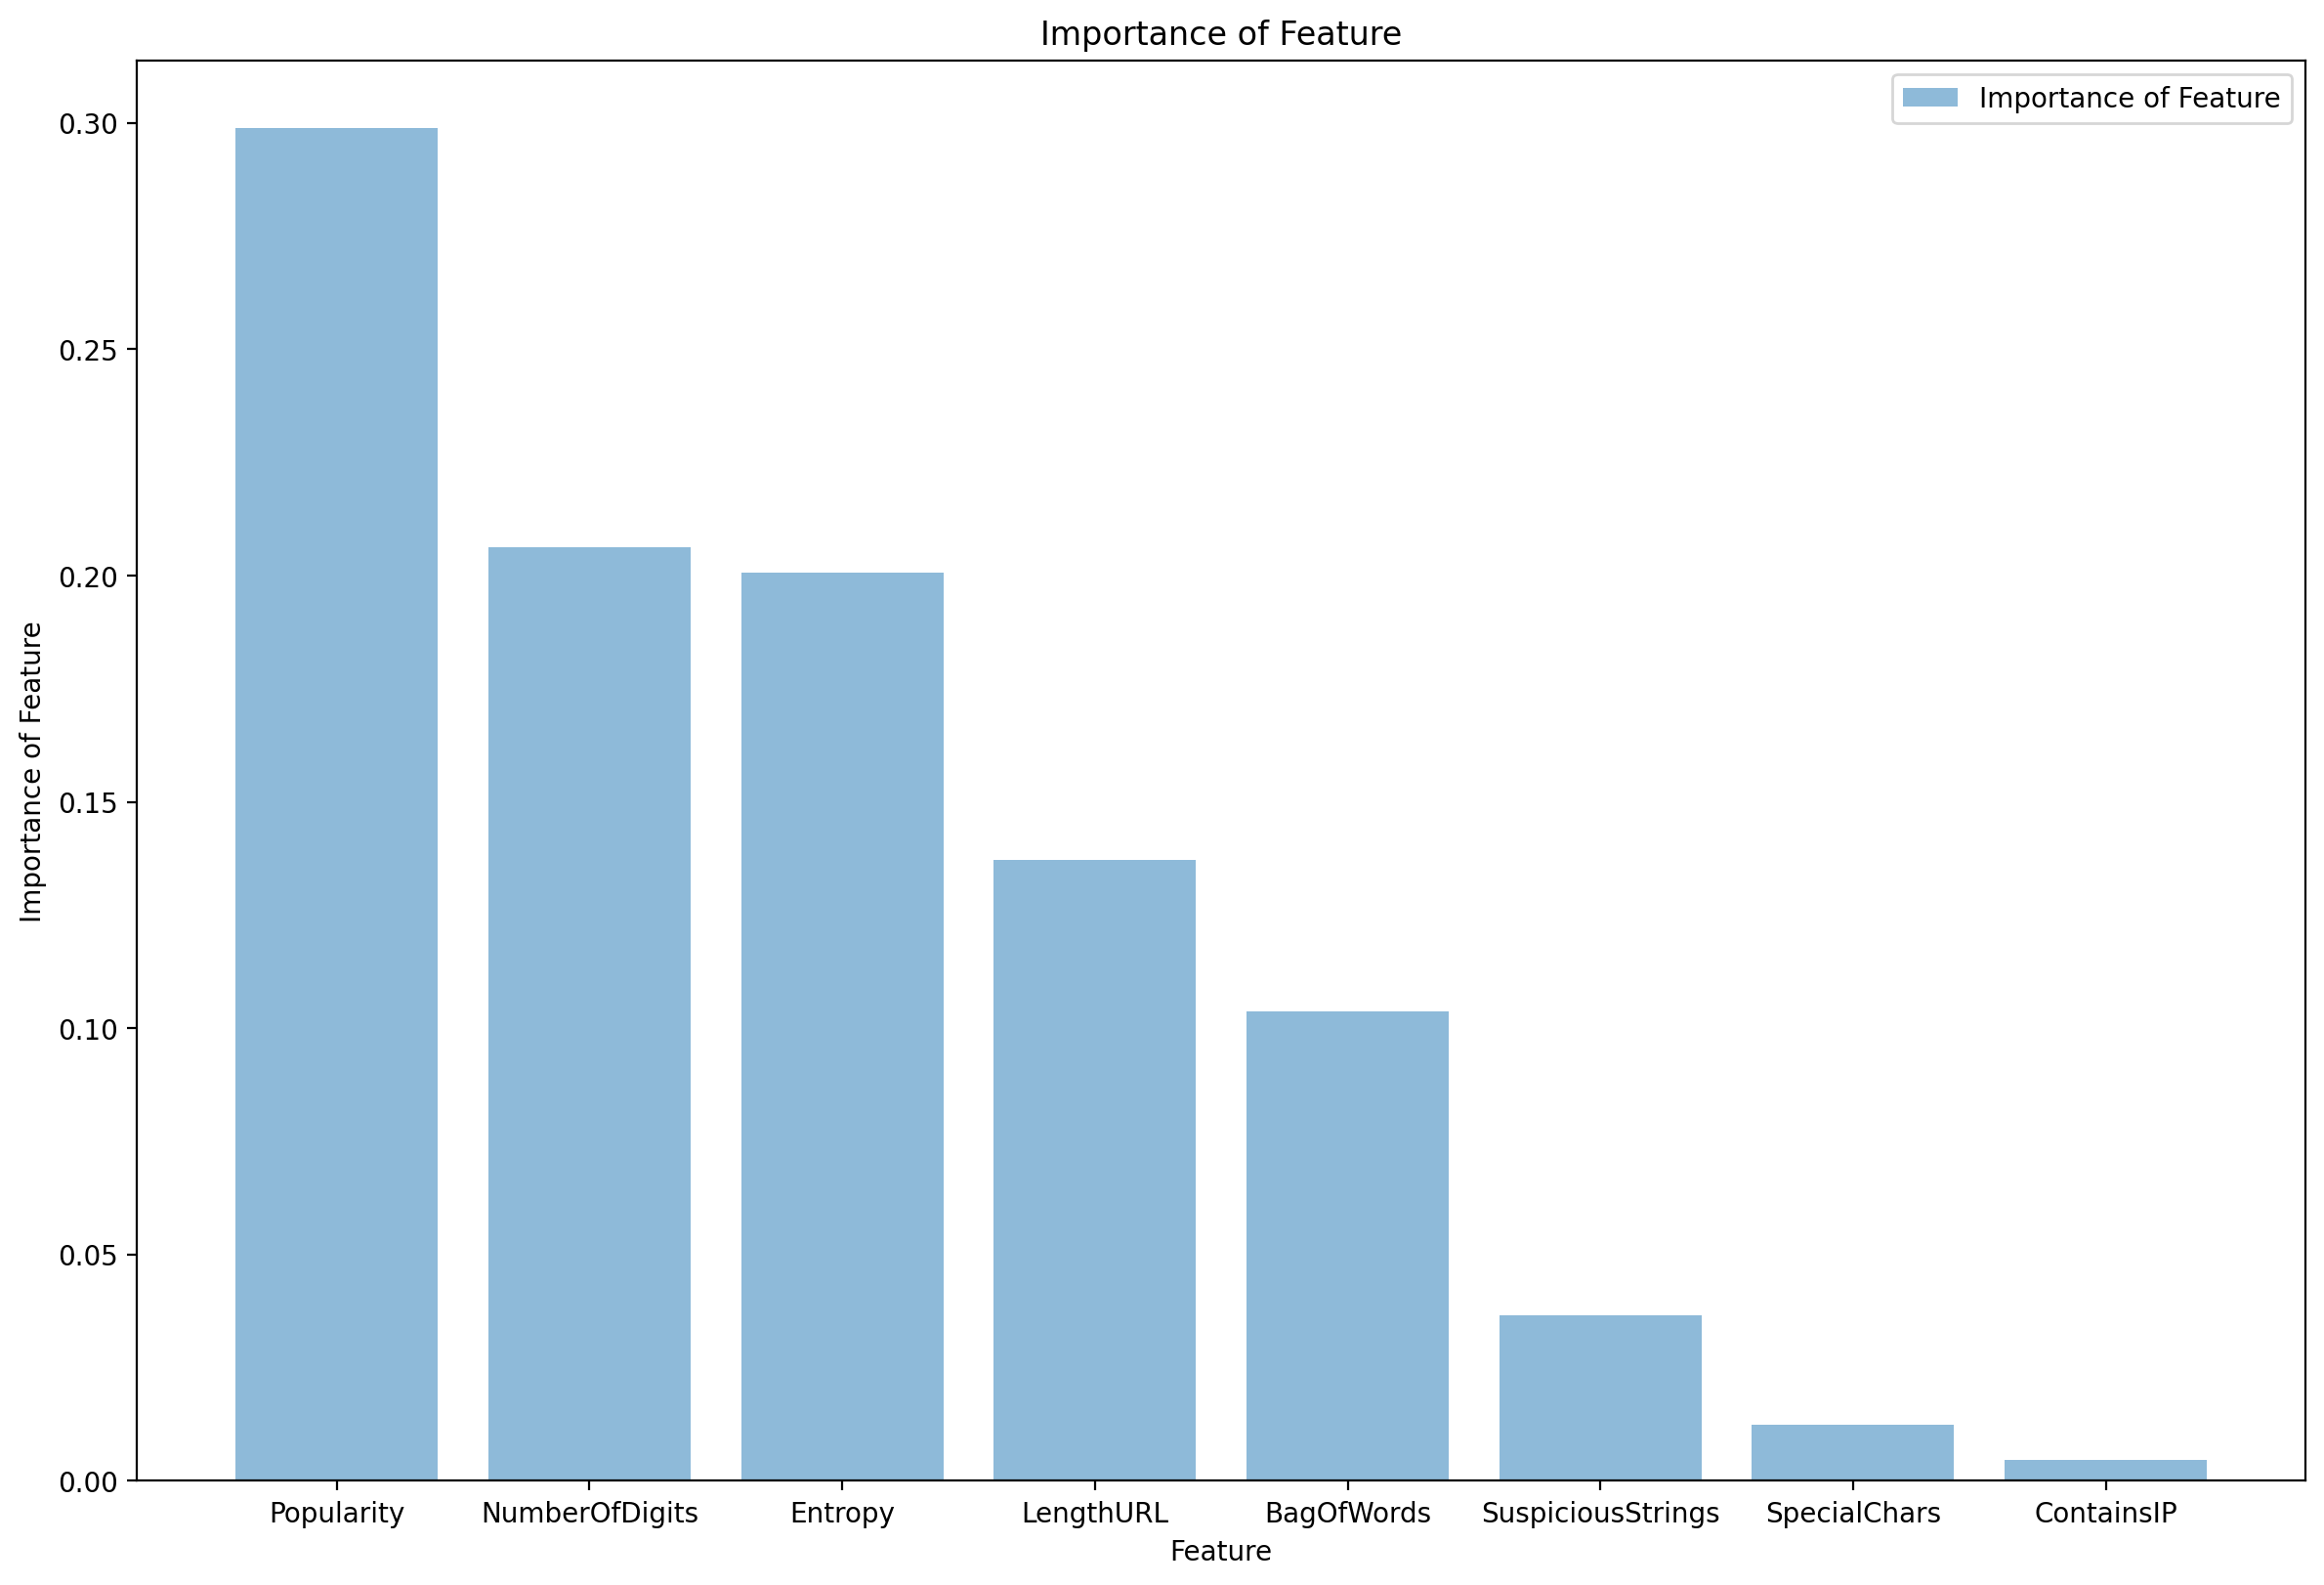

In [19]:
plt.figure(figsize = (12, 8), dpi = 200)
plt.bar(importance_dict_sorted.keys(),importance_dict_sorted.values(), alpha=0.5, align='center',label='Importance of Feature')
plt.ylabel('Importance of Feature')
plt.xlabel('Feature')
plt.legend(loc='best')
plt.tight_layout()
plt.title('Importance of Feature')
plt.savefig('../images/Importance_of_features.jpg', dpi = 300)

Fit the model using the first k descend-sorted features and show the accuracy on test set,k is from 1 to 8

In [20]:
selected_score=list()
clf_selected = RandomForestClassifier(n_jobs = -1,max_features = 'sqrt' ,n_estimators = 150, oob_score = True, random_state = 0)
for k in range(1,9):
    X_train_selected=X_train[:,feature_index_sorted[0:k]]
    X_test_selected=X_test[:,feature_index_sorted[0:k]]
    clf_selected.fit(X_train_selected,y_train)
    y_test_selected_predicted=clf_selected.predict(X_test_selected)
    selected_score.append(accuracy_score(y_test,y_test_selected_predicted))

[0.821, 0.8635, 0.837, 0.8605, 0.8915, 0.893, 0.895, 0.8965]


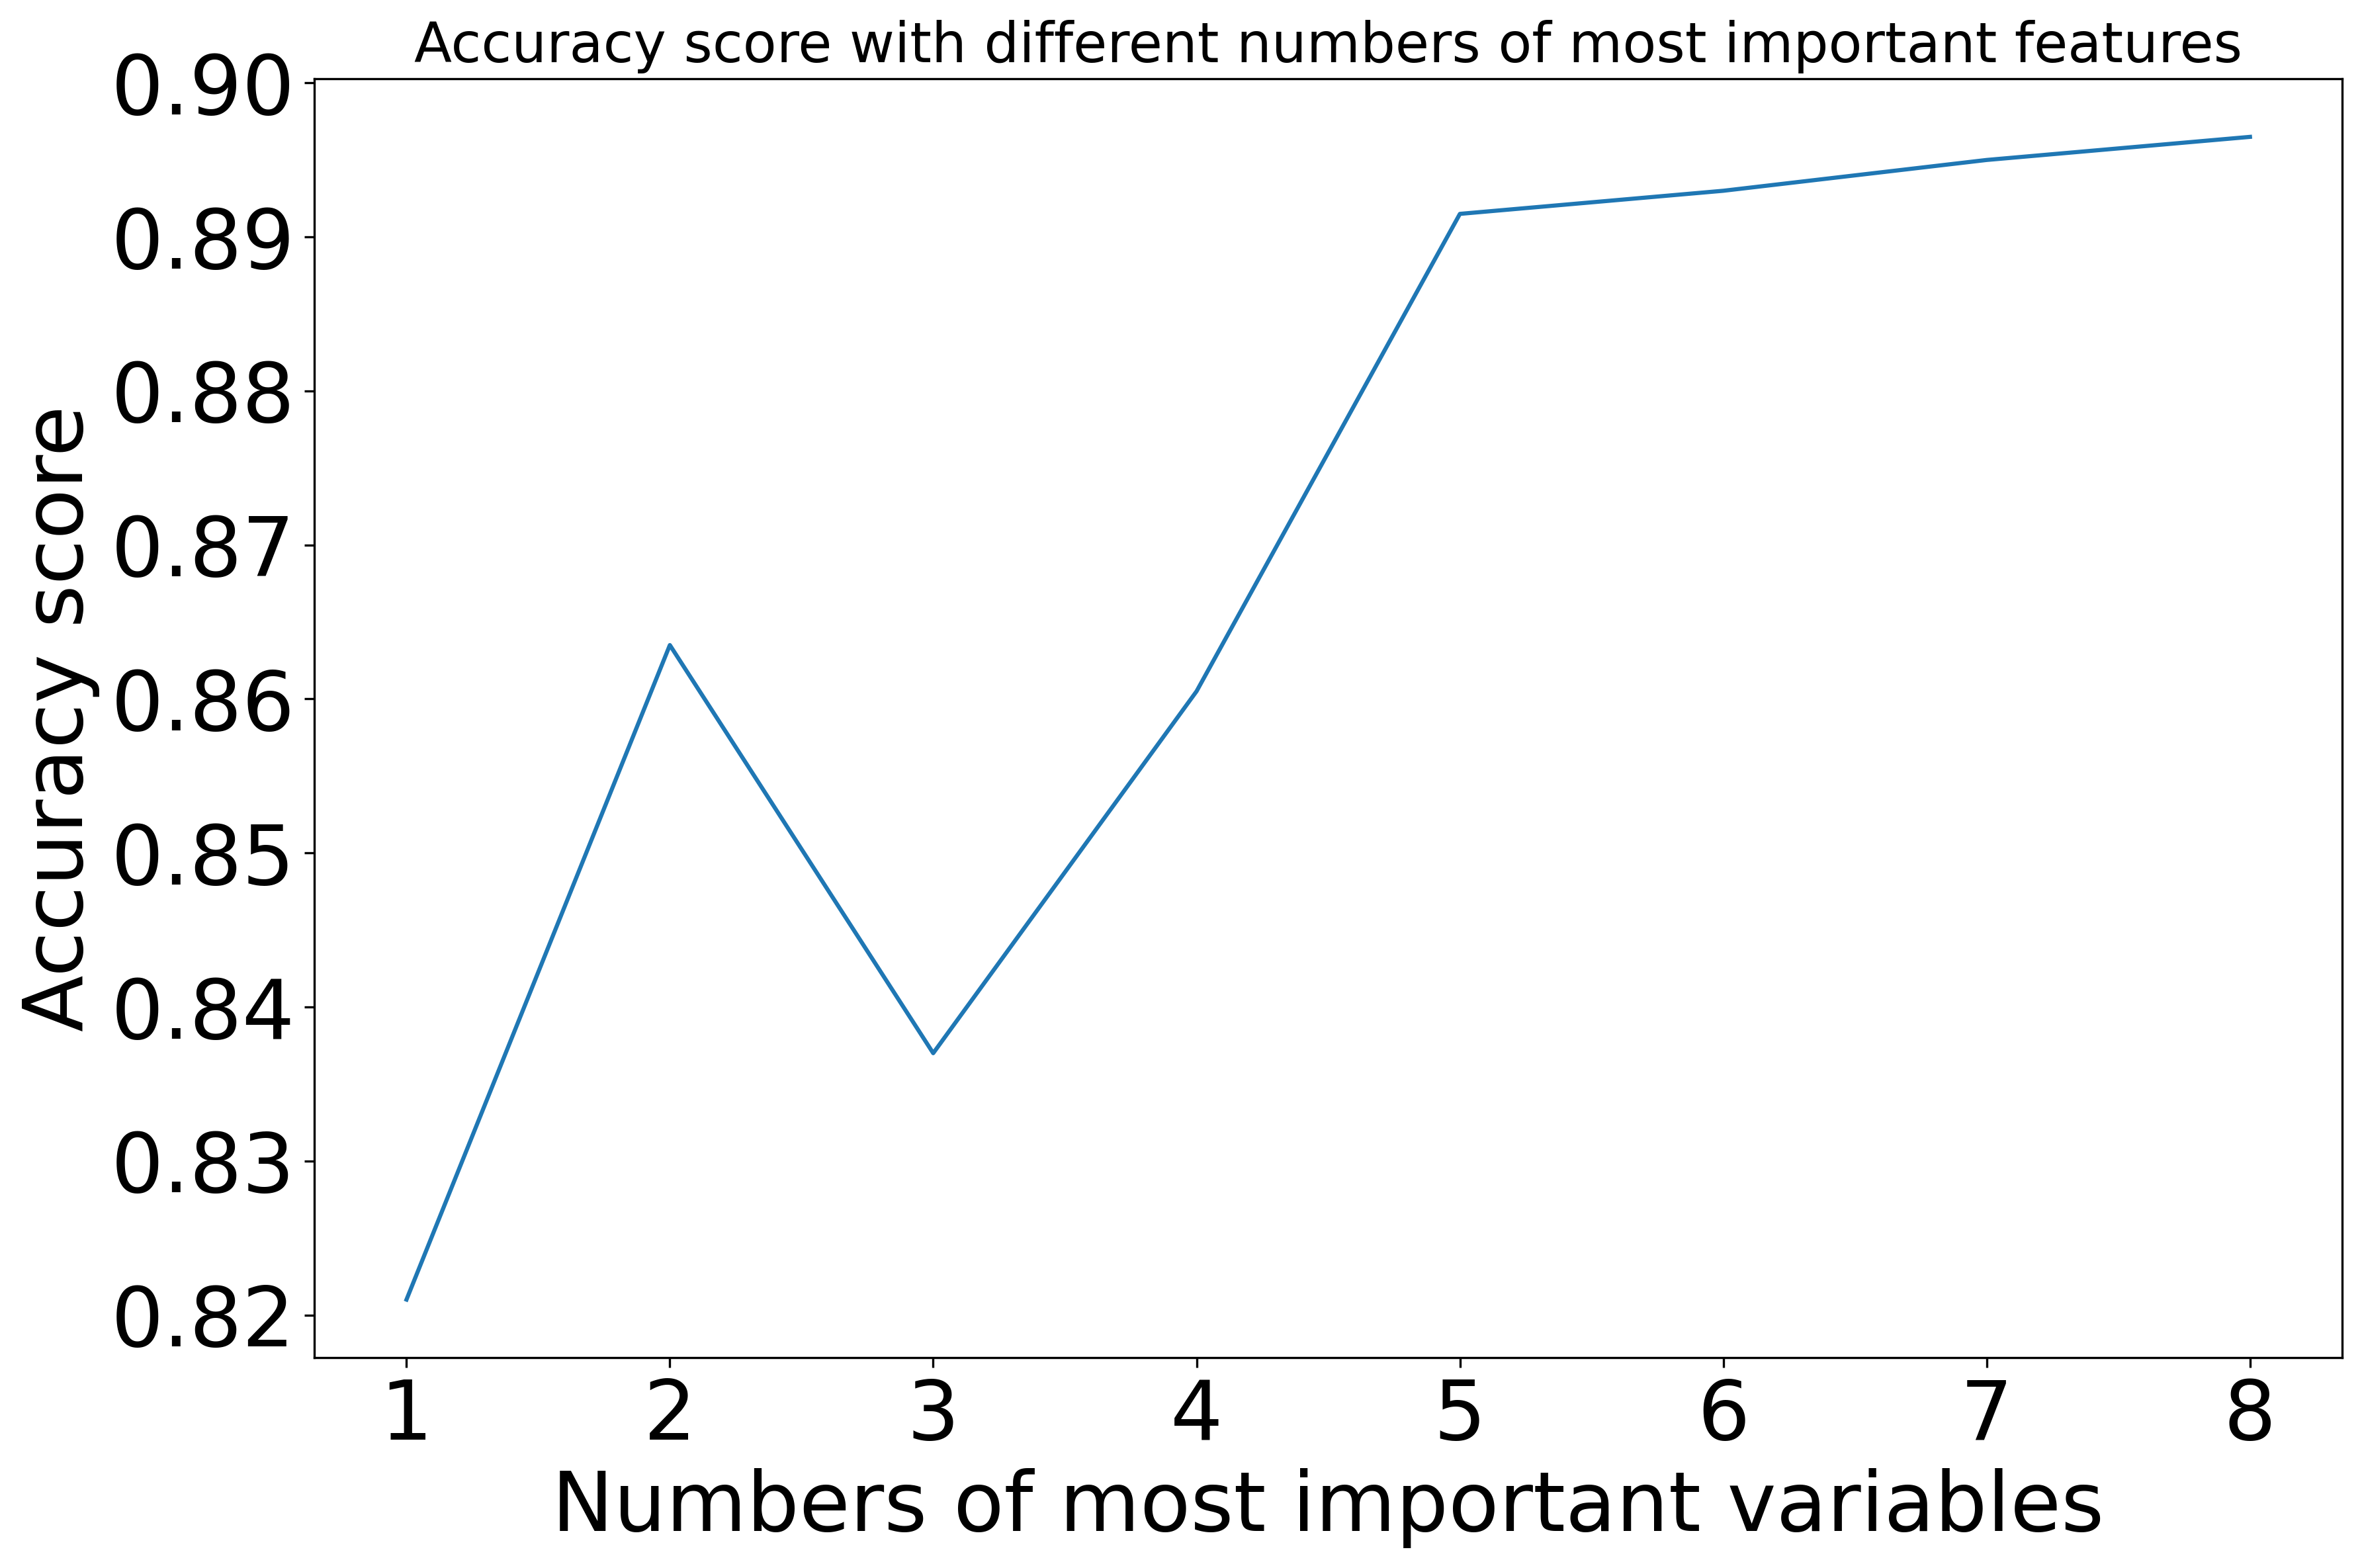

In [21]:
print(selected_score)
plt.figure(figsize = (12, 8), dpi = 300)
plt.plot(list(range(1,9)), selected_score)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.title('Accuracy score with different numbers of most important features', fontsize = 20)
plt.xlabel('Numbers of most important variables', fontsize = 30)
plt.ylabel('Accuracy score', fontsize = 30)
plt.savefig('../images/plot_of_accuracy with different features.jpg', dpi = 300)
plt.tight_layout()
plt.show()

10. Plot **learning curve**.

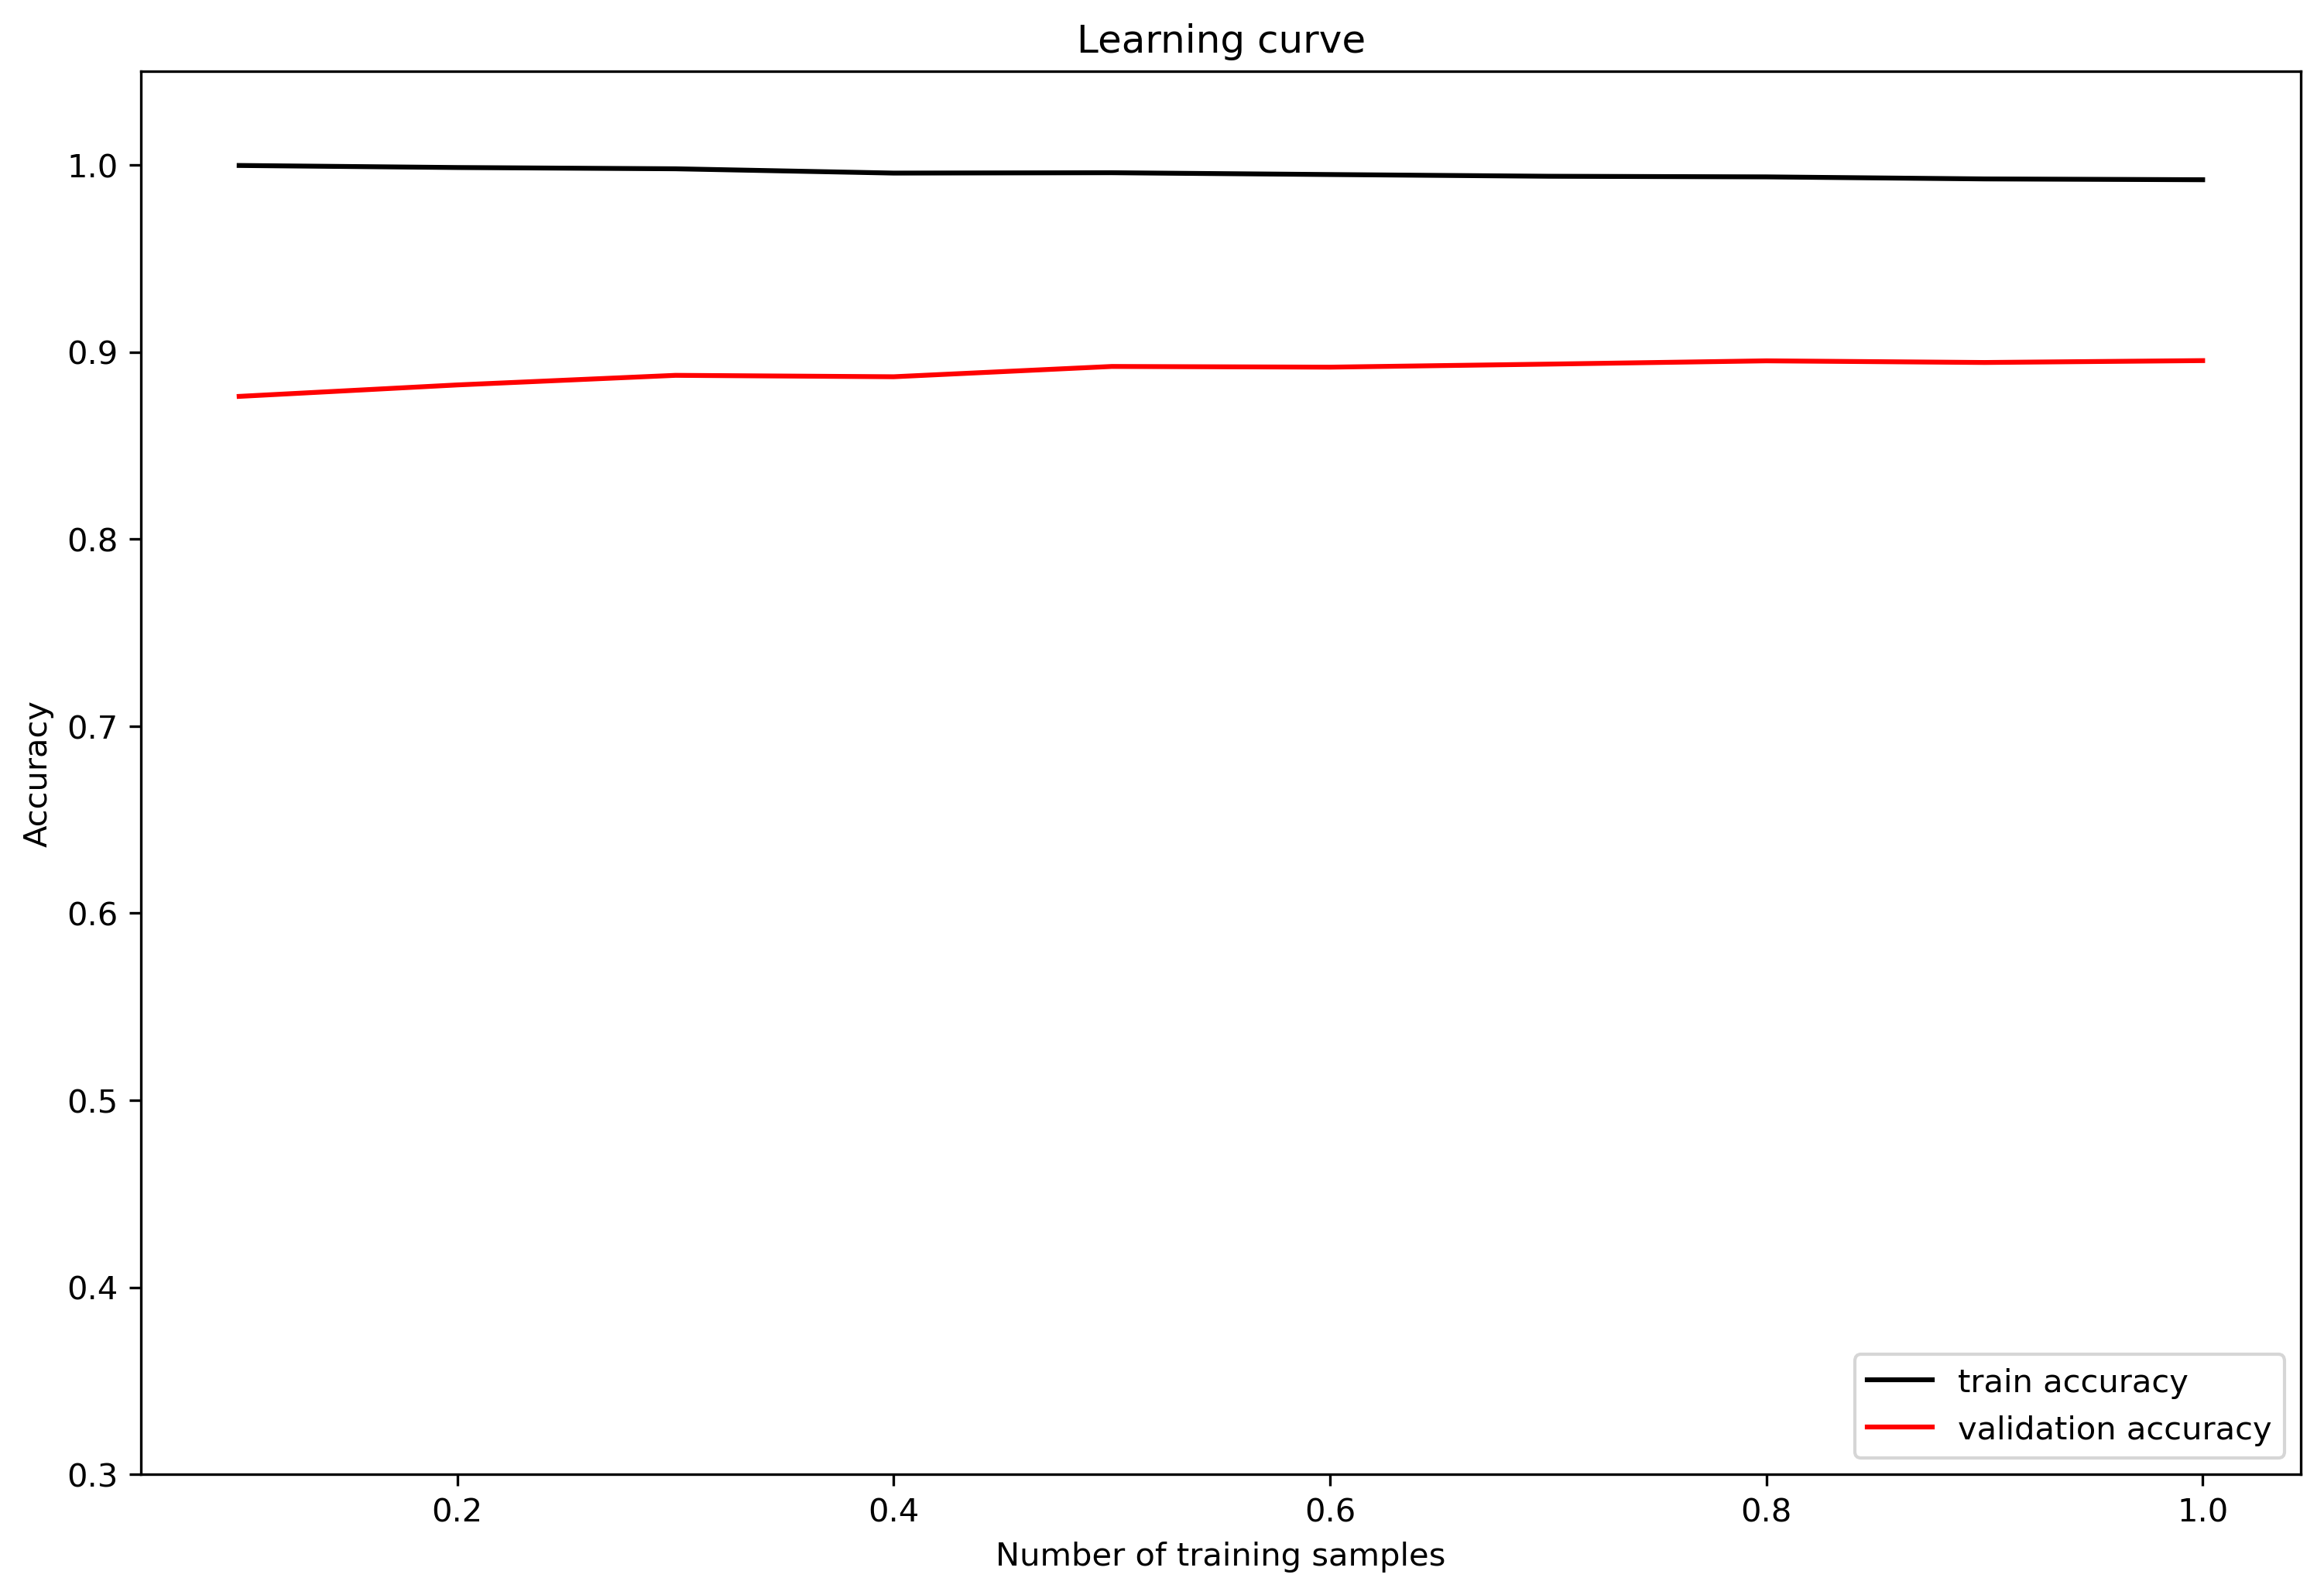

In [22]:
get_learning_curve(clf, X_train, y_train)
plt.savefig('../images/learning_curve.jpg', dpi = 300)
plt.show()

Save the configuration of the classifier and features as a pickle file.

In [23]:
all_features = X.shape[1]
features = []

for feature in range(all_features):
    features.append(df.columns[1+feature])

try:
    print("Saving algorithm and feature list in classifier directory...")
    joblib.dump(CV_clf, 'classifier.pkl')
    open('features.pkl', 'wb').write(pickle.dumps(features))
    print(colored('\n[*] ', 'green') + " Saved.")
except:
    print('\n Error: Algorithm and feature list not saved correctly.\n')

Saving algorithm and feature list in classifier directory...

[*]  Saved.


## Using the model above to identify  whether the url  is malicious

 - **get_url_info** function extracts features from a user supplied.The function extracts all features similarly to extract_features(),but instead saves the extracted features in the form of a dictionary. 

In [24]:
# Get URL information function extracts features from a user supplied
# URL. The function extracts all features similarly to extract_features()
# but instead saves the extracted features in the form of a dictionary. 
def get_url_info(url):
    # Creates a dictionary for features to be stored in.
    features = {}
    
    # Parses input URL to remove http:// or https://.
    parsed_url = parse_url(url)
    # Retrieve URL entropy and store in dictionary.
    feature = URLFeatures(parsed_url)
    entropy = feature.Entropy()
    features['Entropy'] = entropy


    # Store Bag Of Words in dictionary.  
    features['BagOfWords'] = feature.bag_of_words()
    
    # Store Contains IP address in dictionary.
    features['ContainsIP'] = feature.contains_IP()

    # Store URL length in dictionary.
    features['LengthURL'] = feature.url_length()

    # Store amount of special characters in dictionary.
    features['SpecialChars'] = feature.special_chars()

    # Store amount of suspicious strings in dictionary.
    features['SuspiciousStrings'] = feature.suspicious_strings()

    # Store number of digits within the URL in dictionary.
    features['NumberOfDigits'] = feature.num_digits()

    # Store site popularity in dictionary.
    features['Popularity'] = feature.popularity()

    # Store Google Safebrowsing verdict in dictionary.
    #apikey = base64.b64decode('QUl6YVN5QV9XbU53MHRyZTEybWtMOE1qYUExY0c3Smd4SnRuU0lv')
    #apikey = apikey.decode('utf-8')
    #safe = SafeBrowse(apikey)
    #features['Safebrowsing'] = safe.threat_matches_find(url) 

    # Return features dictionary.
    return features

- **classify_url** function passes in the input URL and classifies it as malicious or benign. 

In [25]:
def classify_url(url):

    # Loads classifier and feature configurations.
    clf = joblib.load('classifier.pkl')

    features = pickle.loads(open(
        'features.pkl',
        'rb').read())
    
    # Extracts features from input URL.
    data = get_url_info(url)
    feature_list = list(map(lambda x:data[x], features))

    # Classifies input URL as malicious or benign.
    result = clf.predict([feature_list])[0]

    if result == 0:
        print("MLURL has classified URL %s as " % url + colored("benign", 'green') + '.')
    else: 
        print("MLURL has classified URL %s as " % url + colored("malicious", 'red') + '.')
    
    return result

- **check_valid_url** function checks whether or not the input URL to classify is in a valid format.


In [26]:
# Check valid URL function checks whether or not the input
# URL to classify is in a valid format.
def check_valid_url(url):
    print("\n[+] Validating URL format...")
    reg = re.compile('^(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?$')
    
    if re.match(reg, str(url)):
        print("URL is valid.")
    else:
        print("Error: URL is not valid. Please input a valid URL format. ")
        return(0)

- **apply_classify_url** function combine the above 3 functions

In [27]:
def apply_classify_url(url):
    if check_valid_url(url)==0:
        return;
    print("Features of this url:" , get_url_info(url))
    classify_url(url)

- **url_test** is a out-of-sample url set,users can choose one url and run our code to check and compare the result

In [28]:
top_website= pd.read_csv('top1m_rank.csv', delimiter='|', usecols = ['URL'], squeeze = True)
url_test = pd.read_csv("URL_test.csv")
url_test

,URL,TYPE
0,ipv6.microsoft.com,0
1,advertising.com,0
2,outlook.office365.com,0
3,mp.microsoft.com,0
4,init-p01st.push.apple.com,0
5,weather.microsoft.com,0
6,googleads4.g.doubleclick.net,0
7,adsrvr.org,0
8,bluekai.com,0
9,ogs.google.com,0


- User can choose any url of url_test dataset or pass any url manually to test_url to classify whether it is malicious.

In [29]:
# choose any url on url_test
test_url=url_test['URL'][31]
test_url

'61kx.uk-insolvencydirect.com/sending_data/in_cgi/bbwp/cases/Inquiry.php'

- Apply our combined function to test an out-of-sample URL to classify whether it is malicious.

In [30]:
apply_classify_url(test_url)


[+] Validating URL format...
URL is valid.
Features of this url: {'Entropy': 4.639065697445789, 'BagOfWords': 10, 'ContainsIP': 0, 'LengthURL': 71, 'SpecialChars': 0, 'SuspiciousStrings': 0, 'NumberOfDigits': 2, 'Popularity': 0}
MLURL has classified URL 61kx.uk-insolvencydirect.com/sending_data/in_cgi/bbwp/cases/Inquiry.php as malicious.
